In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import time

# Set up variables

In [2]:
# Problem data.
m = 4# Problem data.
n_values = np.arange(start=100, stop=4001, step=100)
b = np.ones(m)

In [3]:
# Number of times to solve the dual equation.
num_dual_samples = 100

# Number of times to solve the stochastic equation.
num_stoc_samples = 10**5

In [4]:
# Set random seed for reproducability.

np.random.seed(23)

In [5]:
def generate_pi():
    rv = np.random.uniform(0, 1)
    return 2**(int(-1*np.log2(rv)) + 1)

In [6]:
def generate_pi(a):
    rv = np.random.uniform(0, 1)
    return 2**(int(-1*np.log2(rv)) + 1)

# Solve for the stochastic program

In [7]:
# Solve for the stochastic program.

# This is deterministic.

# From TA office hours: We cannot use the expectations
# of A and pi instead of their samples of A and pi,
# because we cannot exchange the function and inequality.
# Therefore, we have to generate very many samples of A 
# and pi, and truly calculate the expectation.
print("Stochastic Program Results")

# Create dictionary to store stochastic program results
n_to_stochastic_p = dict()

start = time.time()

for n in n_values:
    # Solve the stochastic problem.
    d = b / n
    
    # Construct the stochastic problem.
    p = cp.Variable(m)
    
    A = np.random.uniform(-0.5, 1, (m, num_stoc_samples))
    pi = np.fromfunction(generate_pi, (num_stoc_samples,))
        
    objective = cp.Minimize((d @ p) + (1/num_stoc_samples)*cp.sum(cp.maximum(0,pi - (np.transpose(A) @ p))))

    constraints = [p >= 0]

    prob = cp.Problem(objective, constraints)

    # Solve the stochastic problem.
    result = prob.solve()
    now = time.time()
    print("\nWith n=%d, iteration completed in %.2f s" % (n, now - start))
    print(p.value)
    
    n_to_stochastic_p[n] = p.value
    

Stochastic Program Results

With n=100, iteration completed in 2.64 s
[5.6376725  5.67822171 5.74884233 5.65566   ]


/opt/anaconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(



With n=200, iteration completed in 9.74 s
[6.28016575 6.30865577 6.28828597 6.41951486]

With n=300, iteration completed in 12.42 s
[52.55771416 53.08091896 52.44470576 52.95654439]

With n=400, iteration completed in 19.48 s
[13.54083443 13.46149103 13.39266298 13.44570393]

With n=500, iteration completed in 21.91 s
[3.36141135 3.39605558 3.45632204 3.37752064]

With n=600, iteration completed in 28.52 s
[3.52259585 3.47661264 3.51053825 3.48990015]

With n=700, iteration completed in 35.53 s
[3.48802987 3.4920915  3.53297624 3.47683626]

With n=800, iteration completed in 42.46 s
[13.92749071 14.07383619 14.08507019 13.85740506]

With n=900, iteration completed in 49.27 s
[55.96327189 55.75655196 55.84883645 55.6714444 ]

With n=1000, iteration completed in 51.70 s
[6.96407955 7.17707795 7.01902079 7.11466423]

With n=1100, iteration completed in 58.69 s
[3.50815704 3.48510859 3.56471778 3.51213851]

With n=1200, iteration completed in 61.04 s
[3.57015528 3.54961975 3.51663906 3.57

# Solve for the dual problem for various values of n

In [9]:
# Create dictionaries to save results of simulations

n_to_diffs = dict()
n_to_mean_diffs = dict()
n_to_log_factors = dict()
n_to_C = dict()

##########################################################
# Solve the dual problem.
    
for n in n_values:
    d = b / n
    
    # Create an array to store all of the simulations.
    p_n_values = np.zeros((num_dual_samples, m))
    
    # Solve for one iteration of the offline dual optimal solution.
    for i in range(num_dual_samples):
        # Generate sample A_j and pi_j's (all at once in array)
        
        A = np.random.uniform(-0.5, 1, (m, n))
        pi = np.fromfunction(generate_pi, (n,))

        
        # Construct the stochastic problem.
        p_n = cp.Variable(m)

        # We could do the sum of up to t terms if this was truly online;
        # however since this is offline we can use matrix operations.

        objective = cp.Minimize((d @ p_n) + (1/n)*cp.sum(cp.maximum(0,pi - (np.transpose(A) @ p_n))))

        constraints = [p_n >= 0]

        prob = cp.Problem(objective, constraints)

        # Solve the offline dual problem.
        result = prob.solve()

        p_n_values[i] = p_n.value
        
        
    
    # Compute the 2-norm difference from the stochastic solution
    diffs = [np.linalg.norm(p_n_values[i]-n_to_stochastic_p[n], ord=2)**2 for i in range(num_dual_samples)]
    
    # Compute the log difference based on m and n
    log_factor = m*np.log(m)*np.log(np.log(n))/n
    
    # Compute the coefficient C from dividing the mean of the differences by the log_factor
    C = np.mean(diffs) / log_factor
    
    # Save all results to the dictionary
    n_to_diffs[n] = diffs
    n_to_mean_diffs[n] = np.mean(diffs)
    n_to_log_factors[n] = log_factor
    n_to_C[n] = C
    
    # Print results
    print("For n = %d" % (n))
    print("Average of all dual solutions: %s" % (np.mean(p_n_values, axis=0)))
    print("Expectation of L2 norm between p*n and p* is: %.2f" % (np.mean(diffs)))
    print("m log m log log n / n for m=%d and n=%d is: %.2f" % (m, n, log_factor))
    print("Constant C is: %.3f\n" % (C))

For n = 100
Average of all dual solutions: [24.41023951 24.54307098 24.4018076  19.30080618]
Expectation of L2 norm between p*n and p* is: 31861.45
m log m log log n / n for m=4 and n=100 is: 0.08
Constant C is: 376235.687

For n = 200
Average of all dual solutions: [15.22722583 15.62749508 14.74559834 15.1047903 ]
Expectation of L2 norm between p*n and p* is: 9006.29
m log m log log n / n for m=4 and n=200 is: 0.05
Constant C is: 194815.560

For n = 300
Average of all dual solutions: [16.73499314 16.43343561 17.24484771 14.99908685]
Expectation of L2 norm between p*n and p* is: 14895.15
m log m log log n / n for m=4 and n=300 is: 0.03
Constant C is: 462828.111

For n = 400
Average of all dual solutions: [11.93628876 11.42431602 12.02838032 11.85933198]
Expectation of L2 norm between p*n and p* is: 2368.11
m log m log log n / n for m=4 and n=400 is: 0.02
Constant C is: 95414.136

For n = 500
Average of all dual solutions: [15.8553422  15.56386614 14.69862585 16.15758315]
Expectation of

For n = 3800
Average of all dual solutions: [14.94226215 14.90290841 14.60181734 14.83918143]
Expectation of L2 norm between p*n and p* is: 4695.43
m log m log log n / n for m=4 and n=3800 is: 0.00
Constant C is: 1525448.818

For n = 3900
Average of all dual solutions: [22.7781573  21.51740759 23.28353665 22.87375386]
Expectation of L2 norm between p*n and p* is: 38614.00
m log m log log n / n for m=4 and n=3900 is: 0.00
Constant C is: 12855860.844

For n = 4000
Average of all dual solutions: [20.8259499  21.23674496 20.90225778 20.5370277 ]
Expectation of L2 norm between p*n and p* is: 13300.99
m log m log log n / n for m=4 and n=4000 is: 0.00
Constant C is: 4535318.049



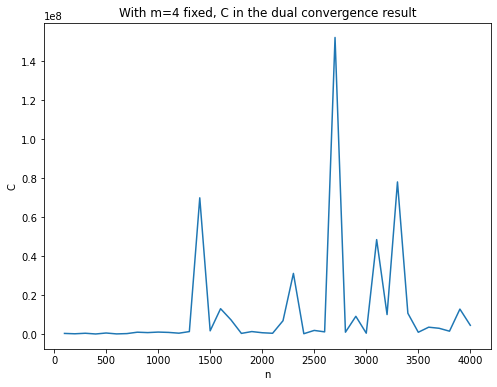

In [10]:
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(list(n_to_C.keys()), list(n_to_C.values()))
plt.xlabel("n")
plt.ylabel("C")
plt.title("With m=%d fixed, C in the dual convergence result" % (m))
plt.show()


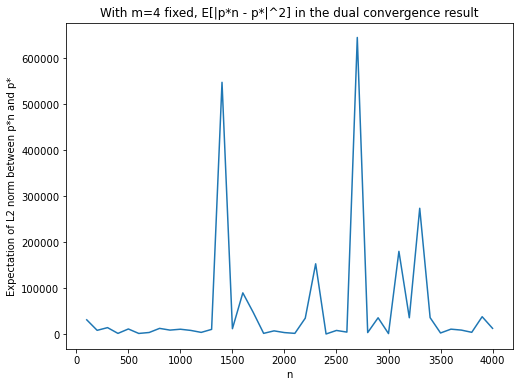

In [11]:
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(list(n_to_diffs.keys()), list(n_to_mean_diffs.values()))
plt.xlabel("n")
plt.ylabel("Expectation of L2 norm between p*n and p*")
plt.title("With m=%d fixed, E[|p*n - p*|^2] in the dual convergence result" % (m))
plt.show()

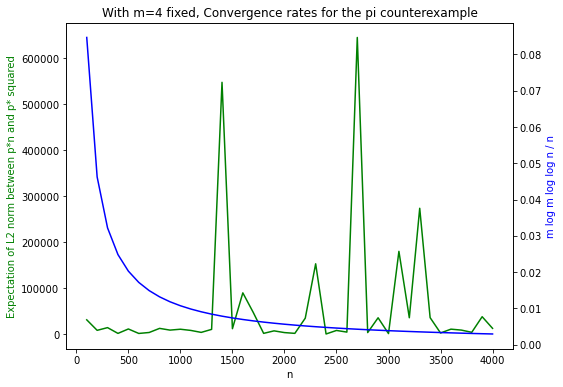

In [12]:
fig, ax1 = plt.subplots(figsize=(8,6))


ax2 = ax1.twinx()

x = list(n_to_diffs.keys())
y1 = list(n_to_mean_diffs.values())
y2 = [m*np.log(m)*np.log(np.log(n))/n for n in x]

ax1.plot(x, y1, 'g-', label="Expectation of L2 norm between p*n and p* squared")
ax2.plot(x, y2, 'b-', label='m log m log log n / n')
ax1.set_xlabel("n")
ax1.set_ylabel("Expectation of L2 norm between p*n and p* squared", color='g')
ax2.set_ylabel("m log m log log n / n", color='b')
plt.title("With m=%d fixed, Convergence rates for the pi counterexample" % (m))
#plt.legend()

plt.show()